In [2]:
import re, os
import burnman
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from astropy import constants 
from astropy import units as u
from burnman import minerals, Composite,Composition, Layer, Planet, Mineral
from burnman.tools.chemistry import formula_mass

Constantes

In [3]:
G = constants.G.value
R_gas = constants.R.value
GPa = 1e9 #Pa
km = 1000 #m
mWm2 = 1e-3 #w/m2
den = 1000/100**3 #g/cm^-3
deg = 180/np.pi
rad = 1/deg

#Tierra
Me = constants.M_earth.value
Re = constants.R_earth.value
R_core = 0.55*Re
Tsurface = 300 

P_ref = 1e5     # Pa
T_ref = 298.0   # K

Funciones

In [4]:
def parse_norm(header_lines):
  """Extrae el dict #norm= {...} si existe. Devuelve dict o {}."""
  for L in header_lines:
    if L.strip().startswith('#norm='):
      txt = L.strip()[len("#norm="):]

      try:
        norm = eval(txt)
        return norm

      except Exception as e:
        print("No pude evaluar #norm:", e)

  return {}


def read_struc_dat(path):
  """Lee STRUC.dat, devuelve header (líneas #) y data array (np.array)."""
  header = []
  data_lines = []
  layers = {}
  with open(path,'r') as f:
    for line in f:
      if line.startswith('#'):
        header.append(line.rstrip("\n"))
      elif line.strip() == '':
        continue
      else:
        data_lines.append(line)

      if line.startswith('#layer'):
        parts = line.split()
        if len(parts) >= 3:
          name = parts[1]
          frac = float(parts[2])
          layers[name] = frac


  data = np.loadtxt(data_lines)
  cols = ['ur','r','mr','rho','P','g','phi','T','composition']
  df = pd.DataFrame(data, columns=cols)
  df.attrs['header'] = header
  df.attrs['norm'] = parse_norm(header)
  df.attrs['composition'] = layers
  return df

def read_trevol_dat(path):
  """Lee TEVOL.dat, devuelve header (líneas #) y data array (np.array)."""
  header_line = None
  with open(path,'r') as f:
    for line in f:
      if line.startswith('#'):
        header_line = line.lstrip("\n").strip()
        break

  if header_line is None:
    raise Exception("No se encontró línea header que empiece con '#' en " + path)

  cols = [re.sub(r'\[.*?\]', '', c).strip() for c in re.split(r'\s+', header_line) if c.strip()!='']

  try:
    df = pd.read_csv(path, comment='#', sep='\s+', header=None, names=cols, engine='python')
    return df
  except Exception as e:
    data = np.genfromtxt(path, comments='#', invalid_raise=False)
    if data.ndim == 1:
      data = data.reshape(1, -1)
    if data.shape[1] != len(cols):
      raise ValueError(f"Lectura fallida: datos con forma {data.shape} pero {len(cols)} columnas esperadas. Errores:\n 1) {e}\n")
    df = pd.DataFrame(data, columns=cols)
    return df


def g(path_struc):
  data_struc = read_struc_dat(path_struc)
  rs = np.array(data_struc.r)
  mrs = np.array(data_struc.mr)
  Rps = Re * rs #m
  Mps = Me * mrs #kg
  gs = np.zeros_like(rs)
  nz = rs > 0
  gs[nz] = G * Mps[nz] / Rps[nz]**2
  return gs

def getRadius(path_struc):
  data_struc = read_struc_dat(path_struc)
  norm = data_struc.attrs['norm']
  if 'R' in norm:
    try:
      return norm['R']
    except Exception:
      pass

  try:
    r = data_struc.r[-1]
    return r
  except Exception:
    return None

def getMass(path_struc):
  data_struc = read_struc_dat(path_struc)
  norm = data_struc.attrs['norm']
  if 'M' in norm:
    try:
      return norm['M']
    except Exception:
      pass
  try:
    m = data_struc.mr[-1]
    return m
  except Exception:
    return None

def getJQ(path_struc, path_tevol):
  data_struc = read_struc_dat(path_struc)
  data_trevol = read_trevol_dat(path_tevol)

  Rps = np.array(data_struc.r) * Re
  Qs = np.array(data_trevol.Qm)
  A = 4 * np.pi * Rps[-1]**2
  JQ = Qs[-1] / A
  return JQ

def get_CMF_IMF(modelname):
  model = re.match(r'^CMF_([0-9.+-eE]+)-IMF_([0-9.+-eE]+)$', modelname)
  if model:
    try:
      return float(model.group(1)), float(model.group(2))
    except Exception:
      return None, None
  return None, None

def table_model(model_folder, Qcol='Qm' ):

  model_folder = os.path.abspath(model_folder)
  if not os.path.isdir(model_folder):
        raise FileNotFoundError(f"No existe carpeta: {model_folder}")

  cmf, imf = get_CMF_IMF(os.path.basename(model_folder))

  files = sorted(os.listdir(model_folder))
  STRUC_files = [f for f in files if f.endswith('STRUC.dat')]
  TEVOL_files = [f for f in files if f.endswith('TEVOL.dat')]

  rows = []
  if len(TEVOL_files) == 0:
    raise FileNotFoundError(f"No se encontraron archivos TEVOL.dat en {model_folder}")
    return pd.DataFrame(rows)

  for tfile in TEVOL_files:
    TEVOL_path = os.path.join(model_folder, tfile)
    _rx_M = re.compile(r'^M([0-9.+-eE]+)-') # Modified regex to capture only the number before the hyphen
    base = os.path.basename(tfile)
    m = float(re.search(_rx_M, base).group(1))

    matching_struc = None
    if m is not None:
      for sfile in STRUC_files:
        if sfile.startswith(f'M{m:0.2f}-') or sfile.startswith(f'M{m}-'):
          matching_struc = sfile
          break

    if matching_struc is None:
      raise FileNotFoundError(f"No se encontró archivo STRUC.dat para M={m} en {model_folder}")

    STRUC_path = os.path.join(model_folder, matching_struc)

    data_struc = read_struc_dat(STRUC_path)
    data_trevol = read_trevol_dat(TEVOL_path)

    Mp = getMass(STRUC_path)
    Rp = getRadius(STRUC_path)

    try:
      gs = g(STRUC_path)
      g_suf = gs[-1]

    except:
      g_suf = None

    try:
      P_surf = np.array(data_struc['P'])[-1]
      rho__surf = np.array(data_struc['rho'])[-1]
      T_surf = np.array(data_struc['T'])[-1]
    except:
      P_surf = None
      rho__surf = None
      T_surf = None

    try:
      JQ = getJQ(STRUC_path, TEVOL_path)
    except:
      JQ = None

    rows.append({
        'Mp' : Mp,
        'Rp' : Rp,
        'P_surf' : P_surf,
        'rho_surf' : rho__surf,
        'T_surf' : T_surf,
        'g_suf' : g_suf,
        'JQ' : JQ,
    })

    df_out = pd.DataFrame(rows)
    df_out.attrs['cmf'] = cmf
    df_out.attrs['imf'] = imf
    df_out.attrs['rmf'] = 1 - cmf
  return df_out

<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Santiago\AppData\Local\Temp\ipykernel_17284\1488530955.py:62: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(path, comment='#', sep='\s+', header=None, names=cols, engine='python')


Calculo g

In [5]:
path_struc =  "PlanetaryGrid/CMF_0.10-IMF_0.00/M1.00-STRUC.dat"
path_tevol = "PlanetaryGrid/CMF_0.10-IMF_0.00/M1.00-TEVOL.dat"

data_struc = read_struc_dat(path_struc)
data_struc.head()

,ur,r,mr,rho,P,g,phi,T,composition
0,0.000000,0.000000,2.077115e-12,11202.21,2.425128e+11,0.000000,-102596100.0,5000.0,0.0
1,0.005025,0.005223,9.631191e-07,11202.90,2.425943e+11,-0.036779,-102594400.0,5000.0,0.0
2,0.010050,0.010445,2.928931e-06,11203.45,2.426606e+11,-0.049776,-102589100.0,5000.0,0.0
3,0.015075,0.015668,9.644348e-06,11203.40,2.426543e+11,0.049878,-102580500.0,5000.0,0.0
4,0.020101,0.020891,2.036107e-05,11203.14,2.426232e+11,0.151268,-102568400.0,5000.0,0.0


Perfiles de Gravedad

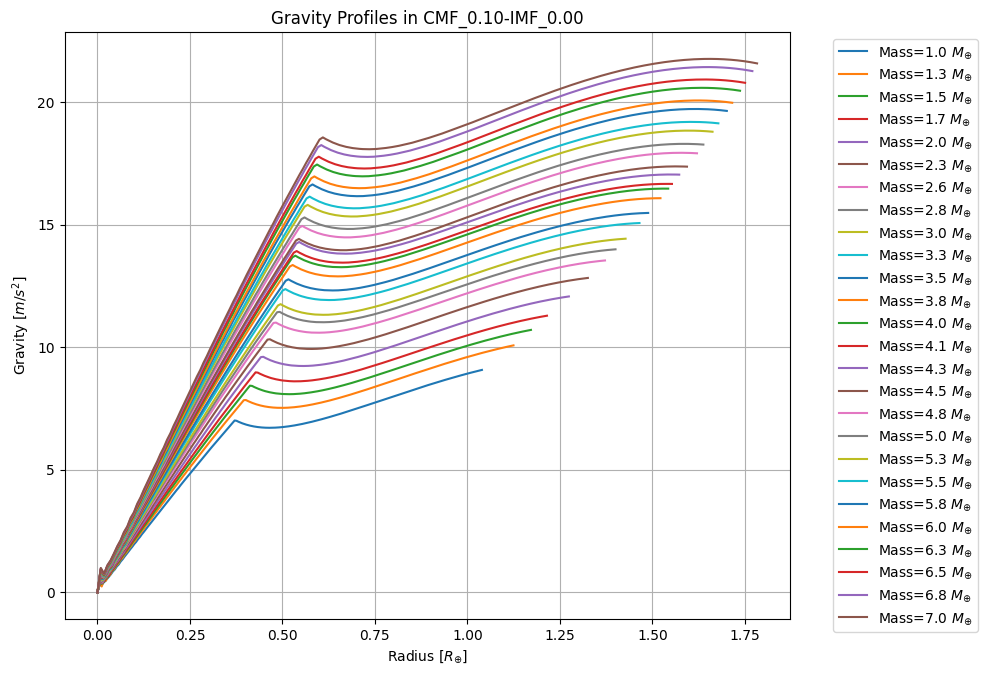

In [6]:
planetary_grid_path = "PlanetaryGrid"
target_folder = "CMF_0.10-IMF_0.00"
folder_path = os.path.join(planetary_grid_path, target_folder)

if not os.path.isdir(folder_path):
    print(f"Error: Folder '{folder_path}' not found.")
else:
    files = sorted(os.listdir(folder_path))
    struc_files = [f for f in files if f.endswith('STRUC.dat')]

    plt.figure(figsize=(10, 7)) # Increased figure size to accommodate the legend

    if not struc_files:
        print(f"No STRUC.dat files found in {folder_path}")
    else:
        for sfile in struc_files:
            path_struc = os.path.join(folder_path, sfile)
            try:
                data_struc = read_struc_dat(path_struc)
                gs = g(path_struc)
                rs = np.array(data_struc.r)

                # Extract mass value from filename for the label
                _rx_M = re.compile(r'^M([0-9.+-eE]+)-')
                base = os.path.basename(sfile)
                m_match = re.search(_rx_M, base)
                mass = float(m_match.group(1)) if m_match else 'N/A'

                plt.plot(rs, gs, label=f'Mass={mass} $M_⊕$')
            except Exception as e:
                print(f"An error occurred while processing {path_struc}: {e}")

        plt.xlabel('Radius $[R_⊕]$')
        plt.ylabel('Gravity $[m/s^2]$')
        plt.title(f'Gravity Profiles in {target_folder}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Calculo $J_Q$

Processing folder: PlanetaryGrid\CMF_0.10-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.20-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.20-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.30-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.30-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.40-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.40-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.50-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.50-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.60-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.60-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.70-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.70-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.80-IMF_0.00
Processing folder: PlanetaryGrid\CMF_0.80-IMF_0.00


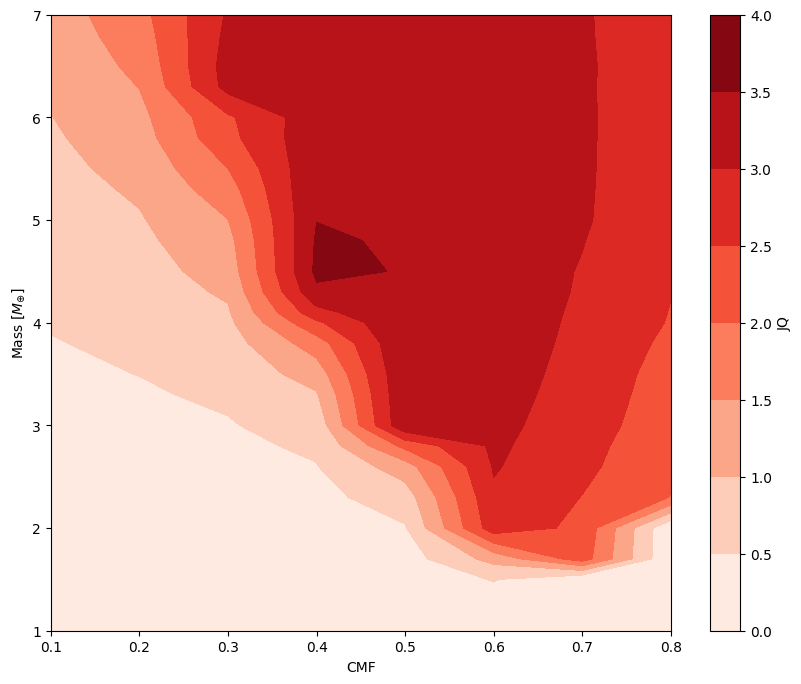

In [7]:
planetary_grid_path = "PlanetaryGrid"
folders = [f for f in sorted(os.listdir(planetary_grid_path)) if f.startswith("CMF_")]
all_data = []

for folder in folders:
  cmf, imf = get_CMF_IMF(folder)
  if imf == 0.00:
    folder_path = os.path.join(planetary_grid_path, folder)
    print(f"Processing folder: {folder_path}")
    try:
      df_model = table_model(folder_path)
      df_model['CMF'] = cmf
      all_data.append(df_model)
    except FileNotFoundError as e:
            print(f"Error processing {folder_path}: {e}")

if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)

    heatmap_data = combined_df.pivot_table(index='Mp', columns='CMF', values='JQ')

    X = heatmap_data.columns.values
    Y = heatmap_data.index.values
    Z = heatmap_data.values

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, Z, cmap="Reds")
    plt.colorbar(contour, label='JQ')
    plt.xlabel('CMF')
    plt.ylabel('Mass $[M_⊕]$')
    plt.show()
else:
    print("No data found for IMF=0.00")

Perfil Geotermico

In [8]:
composition = {
 "upper": {"Quartz":20,"Orthoclase":15,"Albite":32,"Anorthite":8,"Phlogopite":10,"Hornblende":13,"Diopside":1,"Hedenbergite":1,"Enstatite":2,"Ferrosillite":3,"Forsterite":64.04,"Fayalite":4.96,"Pyrope":3.19,"Almandine":9},
 "middle":{"Quartz":15,"Orthoclase":5,"Albite":35,"Anorthite":20,"Hornblende":20,"Diopside":1.96,"Hedenbergite":0.14,"Enstatite":1,"Ferrosillite":1,"Forsterite":63.65,"Fayalite":3.35,"Pyrope":5.58,"Almandine":0.81},
 "lower":{"Quartz":2,"Orthoclase":10,"Albite":10,"Anorthite":18,"Hornblende":47,"Diopside":5.47,"Hedenbergite":0.53,"Enstatite":23.22,"Ferrosillite":1.78,"Forsterite":54.20,"Fayalite":5.80,"Pyrope":9.57,"Almandine":1.42},
 "mantle":{"Forsterite":64.04,"Fayalite":4.96,"Enstatite":15.47,"Ferrosillite":1.53,"Diopside":9.97,"Pyrope":0,"Almandine":2.43}
}

mineral_params = {
 # Parámetros mejorados basados en Hofmeister (1999), Stackhouse (2015), Hasterok & Chapman (2011)
 "Quartz": {"lambda0":6.5,"n":0.5,"KT":60.0,"KTp":4.0,"lambdaRmax":0.5,"TR":1400.0,"omega":300.0},
 "Orthoclase":{"lambda0":2.5,"n":0.5,"KT":60.0,"KTp":4.0,"lambdaRmax":0.2,"TR":1400.0,"omega":300.0},
 "Albite":{"lambda0":3.0,"n":0.5,"KT":60.0,"KTp":4.0,"lambdaRmax":0.3,"TR":1400.0,"omega":300.0},
 "Anorthite":{"lambda0":3.5,"n":0.5,"KT":70.0,"KTp":4.0,"lambdaRmax":0.4,"TR":1400.0,"omega":300.0},
 "Phlogopite":{"lambda0":1.7,"n":0.4,"KT":40.0,"KTp":4.0,"lambdaRmax":0.1,"TR":1300.0,"omega":300.0},
 "Hornblende":{"lambda0":2.2,"n":0.5,"KT":60.0,"KTp":4.0,"lambdaRmax":0.5,"TR":1350.0,"omega":300.0},
 "Diopside":{"lambda0":3.8,"n":0.5,"KT":105.0,"KTp":4.3,"lambdaRmax":1.0,"TR":1400.0,"omega":300.0},
 "Hedenbergite":{"lambda0":3.0,"n":0.5,"KT":100.0,"KTp":4.0,"lambdaRmax":0.8,"TR":1350.0,"omega":300.0},
 "Enstatite":{"lambda0":4.2,"n":0.5,"KT":107.0,"KTp":4.5,"lambdaRmax":1.5,"TR":1300.0,"omega":300.0},
 "Ferrosillite":{"lambda0":3.5,"n":0.5,"KT":100.0,"KTp":4.0,"lambdaRmax":1.0,"TR":1300.0,"omega":300.0},
 "Forsterite":{"lambda0":5.5,"n":0.6,"KT":128.0,"KTp":4.2,"lambdaRmax":3.0,"TR":1200.0,"omega":300.0},
 "Fayalite":{"lambda0":4.5,"n":0.5,"KT":130.0,"KTp":4.0,"lambdaRmax":1.5,"TR":1200.0,"omega":300.0},
 "Pyrope":{"lambda0":4.0,"n":0.6,"KT":171.0,"KTp":4.3,"lambdaRmax":2.0,"TR":1400.0,"omega":300.0},
 "Almandine":{"lambda0":3.8,"n":0.5,"KT":175.0,"KTp":4.5,"lambdaRmax":1.5,"TR":1400.0,"omega":300.0}
}

Quartz = minerals.SLB_2011.qtz()
Albite = minerals.SLB_2011.albite()
Anorthite = minerals.SLB_2011.anorthite()
Diopside = minerals.SLB_2011.diopside()
Hedenbergite = minerals.SLB_2011.hedenbergite()
Enstatite = minerals.SLB_2011.enstatite()
Ferrosillite = minerals.SLB_2011.ferrosilite()
Forsterite = minerals.SLB_2011.forsterite()
Fayalite = minerals.SLB_2011.fayalite()
Pyrope = minerals.SLB_2011.pyrope()
Almandine = minerals.SLB_2011.almandine()
Phlogopite = minerals.JH_2015.phl()
Orthoclase = minerals.HP_2011_ds62.hol()
Hornblende = minerals.SLB_2011.mg_tschermaks()

mineral_objects = {
    "Quartz": Quartz, "Albite": Albite, "Anorthite": Anorthite, "Diopside": Diopside,
    "Hedenbergite": Hedenbergite, "Enstatite": Enstatite, "Ferrosillite": Ferrosillite,
    "Forsterite": Forsterite, "Fayalite": Fayalite, "Pyrope": Pyrope,
    "Almandine": Almandine, "Phlogopite": Phlogopite, "Orthoclase": Orthoclase,
    "Hornblende": Hornblende
}

In [9]:
# ---------------------------
# Funciones de conductividad
# ---------------------------
def lambda_lattice(mineral, T, P=0.0):
    """Aproximación simplificada de la parte lattice dependiente de T y P."""
    p = mineral_params[mineral]
    P_GPa = P/1e9
    KT = p["KT"]
    KTp = p["KTp"]
    lam0 = p["lambda0"]
    n = p["n"]
    return lam0 * (298.0 / T)**n * (1.0 + (KTp/KT)*P_GPa)

def lambda_radiative(mineral, T):
    p = mineral_params[mineral]
    lamRmax = p["lambdaRmax"]
    if lamRmax == 0.0:
        return 0.0
    TR = p["TR"]
    omega = p["omega"]
    return 0.5 * lamRmax * (1.0 + math.erf((T - TR)/omega))

def lambda_effective_VRH(comp_dict, T, P=0.0):
    """
    Conductividad térmica efectiva usando promedio Voigt-Reuss-Hill.
    Más apropiado para agregados policristalinos (Hasterok & Chapman 2011).
    
    Voigt (límite superior): suma ponderada
    Reuss (límite inferior): media armónica
    VRH: promedio de ambos
    """
    lambda_voigt = 0.0
    lambda_reuss_inv = 0.0
    
    for mineral, frac in comp_dict.items():
        lam = lambda_lattice(mineral, T, P) + lambda_radiative(mineral, T)
        lam = max(lam, 1e-6)  # Evitar división por cero
        
        lambda_voigt += frac * lam
        lambda_reuss_inv += frac / lam
    
    lambda_reuss = 1.0 / lambda_reuss_inv
    lambda_vrh = 0.5 * (lambda_voigt + lambda_reuss)
    
    return lambda_vrh

def lambda_effective_for_composition(comp_dict, T, P=0.0):
    """Wrapper para mantener compatibilidad - ahora usa VRH en vez de geométrica."""
    return lambda_effective_VRH(comp_dict, T, P)

def comp_for_depth(zi, composition, boundaries=None):
    """
    Devuelve el diccionario de composición modal correspondiente a la profundidad zi.
    - zi: profundidad (m)
    - composition: dict con claves ['upper','middle','lower','mantle']
    - boundaries: lista de 3 fronteras [d1, d2, d3] (en m)
      Si es None, usa valores por defecto (Tierra).
    """
    if boundaries is None:
        boundaries = [16e3, 23e3, 39e3]

    d1, d2, d3 = boundaries

    if zi < d1:
        return composition["upper"]
    elif zi < d2:
        return composition["middle"]
    elif zi < d3:
        return composition["lower"]
    else:
        return composition["mantle"]

def rho_for_depth(zi):
    return 2800.0 if zi < 39*km else 3300.0


def normalize_modal_dict(modal_dict):
    """Normaliza un dict {mineral: valor} a fracciones que sumen 1 (omite ceros)."""
    comp = {m: v for m, v in modal_dict.items() if v > 0}
    s = sum(comp.values())
    if s <= 0:
        raise ValueError("Suma de composiciones modal <= 0")
    for m in comp:
        comp[m] = comp[m] / s
    return comp

def modal_to_mass_fractions(modal_dict, mineral_objects, P=1e5, T=298.):
    """
    Convierte fracciones modales (volumétricas) a fracciones de masa usando densidades BurnMan.
    modal_dict: {mineral_name: vol_frac} (ya normalizado a suma 1.0)
    mineral_objects: dict con los objetos de BurnMan (ej. Quartz, Forsterite, ...)
    Devuelve: mass_fracs {mineral_name: mass_fraction}
    """
    mass_props = {}
    for name, vol_frac in modal_dict.items():
        if name not in mineral_objects:
            raise ValueError(f"Mineral {name} no encontrado en mineral_objects.")
        mineral = mineral_objects[name]
        # crear Composite de 1 mineral para preguntar densidad en P,T
        # (algunas versiones permiten mineral.set_state; si lanza error usa Composite)
        single = Composite([mineral], [1.0])
        single.set_state(P, T)
        rho = float(single.density)   # kg/m^3
        mass_props[name] = vol_frac * rho

    total = sum(mass_props.values())
    if total <= 0:
        raise ValueError("Suma de propiedades de masa = 0")
    mass_fracs = {name: mp / total for name, mp in mass_props.items()}
    return mass_fracs

def massfracs_to_composite(mass_frac_dict, mineral_objects):
    """
    Convierte fracciones de masa en Composite (fracciones molares internas).
    mass_frac_dict: {mineral_name: mass_frac}
    """
    minerals_list = []
    mols = []
    for name, mass_frac in mass_frac_dict.items():
        if name not in mineral_objects:
            raise ValueError(f"Mineral {name} no encontrado en mineral_objects.")
        m = mineral_objects[name]
        molar_mass = getattr(m, "molar_mass", None)
        if molar_mass is None:
            raise AttributeError(f"El objeto mineral {name} no tiene 'molar_mass' accesible.")

        # moles proporcionales:
        mols.append(mass_frac / molar_mass)
        minerals_list.append(m)

    mols = np.array(mols)
    mole_fracs = (mols / mols.sum()).tolist()
    comp = Composite(minerals_list, mole_fracs)
    return comp

def make_composite_from_modal(modal_dict, mineral_objects, P=1e5, T=298.):
    """
    Pipeline completo: modal -> mass fracs -> mole fracs -> Composite
    modal_dict may be % or fractions; function normalizes it first.
    """
    modal_norm = normalize_modal_dict(modal_dict)
    mass_fracs = modal_to_mass_fractions(modal_norm, mineral_objects, P=P, T=T)
    composite = massfracs_to_composite(mass_fracs, mineral_objects)
    return composite





# Funciones helper para BurnMan: set_state seguro y lectura densidad
def set_composite_state(composite, P, T):
    """
    Lleva composite al estado (P,T). La API de BurnMan puede pedir (P,T) o (T,P).
    Deja el composite en ese estado o lanza excepción.
    """
    try:
        composite.set_state(P, T)
    except Exception:
        composite.set_state(T, P)

def get_density(composite):
    """Devuelve densidad desde composite."""
    if hasattr(composite, "density"):
        r = composite.density
        if callable(r):
            r = r()
        return float(r)
    raise AttributeError("No pude leer densidad del Composite")

def A_profile(z, q_s=None, F=None, D=None,
              boundaries=None,
              A_surface=2.5e-6, 
              h_r=10e3,
              A_mantle=1.5e-08,
              use_exponential=True):
    """
    Devuelve el perfil A(z) [W/m³] con modelo EXPONENCIAL (por defecto) o escalones.
    
    MODELO EXPONENCIAL (use_exponential=True, RECOMENDADO):
    ---------------------------------------------------------
    A(z) = A_surface · exp(-z/h_r)  para z < z_moho
    A(z) = A_mantle                  para z ≥ z_moho
    
    Parámetros:
    -----------
    z : array
        Profundidades (m)
    A_surface : float
        Producción superficial (W/m³). Default: 2.5e-6 (2.5 μW/m³)
    h_r : float
        Profundidad característica (m). Default: 10e3 (10 km)
        Típico: 10-15 km para corteza continental
    A_mantle : float
        Producción en manto (W/m³). Default: 1.5e-08 (0.015 μW/m³)
    boundaries : list
        [d1, d2, d3] en m. d3 se usa como Moho para el modelo exponencial.
        Default: [16e3, 23e3, 39e3]
    use_exponential : bool
        True = modelo exponencial (RECOMENDADO)
        False = modelo escalones (legacy)
    
    MODELO ESCALONES (use_exponential=False, LEGACY):
    --------------------------------------------------
    Requiere parámetros adicionales: q_s, F, D
    Mantiene compatibilidad con código antiguo.
    """
    z = np.asarray(z)
    nz = z.size

    # Valores por defecto de boundaries
    if boundaries is None:
        d1 = 16e3
        d2 = 23e3
        d3 = 39e3
    else:
        if len(boundaries) != 3:
            raise ValueError("boundaries debe ser una lista/tupla con 3 elementos [d1,d2,d3] en metros.")
        d1, d2, d3 = boundaries
        if not (0 <= d1 <= d2 <= d3):
            raise ValueError("boundaries deben cumplir 0 <= d1 <= d2 <= d3")
    
    z_moho = d3  # Usar última frontera como Moho

    # =========================================================================
    # MODELO EXPONENCIAL (NUEVO, RECOMENDADO)
    # =========================================================================
    if use_exponential:
        A_out = np.zeros(nz, dtype=float)
        
        for i, zi in enumerate(z):
            if zi < z_moho:
                # Corteza: decaimiento exponencial
                A_out[i] = A_surface * np.exp(-zi / h_r)
            else:
                # Manto: constante
                A_out[i] = A_mantle
        
        return A_out
    
    # =========================================================================
    # MODELO ESCALONES (LEGACY, para compatibilidad)
    # =========================================================================
    else:
        # Validar parámetros requeridos para modelo escalones
        if q_s is None or F is None or D is None:
            raise ValueError("Modelo escalones requiere q_s, F y D. " +
                           "Usa use_exponential=True para el modelo mejorado.")
        
        if D <= 0:
            raise ValueError("D debe ser > 0 (espesor de la capa productora superior en metros).")
        
        # A en la capa productora superior (A_UC) por modelo de partición
        A_UC = (1.0 - F) * q_s / D
        A_mid_lower = 4e-07  # Valor legacy
        
        A_out = np.zeros(nz, dtype=float)
        for i, zi in enumerate(z):
            if zi < D:
                A_out[i] = A_UC
            elif zi < d1:
                A_out[i] = A_mid_lower
            elif zi < d2:
                A_out[i] = A_mid_lower
            elif zi < d3:
                A_out[i] = A_mid_lower
            else:
                A_out[i] = A_mantle
        
        return A_out


def layer_boundaries_scale_radius(R_planet,
                                          ref_boundaries = [16e3, 23e3, 39e3],
                                          R_ref = Re,
                                          max_fraction_of_radius = 0.5):
    """
    Devuelve [d1,d2,d3] profundidades en metros escaladas por R_planet/R_ref.
    - R_planet: radio del planeta en metros
    - ref_boundaries: lista de profundidades de referencia (Earth) en metros
    - R_ref: radio de referencia (por defecto R_earth)
    - max_fraction_of_radius: evita que una frontera > max_fraction_of_radius * R_planet
      (por seguridad física; default 0.5 => no más profundo que la mitad del radio)
    """
    if R_planet <= 0:
        raise ValueError("R_planet debe ser > 0")
    if len(ref_boundaries) != 3:
        raise ValueError("ref_boundaries debe tener 3 elementos [d1,d2,d3]")

    scale = float(R_planet) / float(R_ref)
    max_depth_allowed = float(R_planet) * float(max_fraction_of_radius)

    scaled = []
    for b in ref_boundaries:
        d = float(b) * scale
        # clamp para evitar profundidades no físicas
        if d < 0.0:
            d = 0.0
        if d > max_depth_allowed:
            d = max_depth_allowed
        scaled.append(d)

    # asegurar orden no decreciente
    scaled = sorted(scaled)
    return scaled

def Data_perfiles(rocks, q_s, z_max, dz, R_planet, M_total,
                  composition, boundaries=None,
                  P_top=1e5, rho_top=2800.0, T_top=273.0, g_top=9.8,
                  # Parámetros modelo EXPONENCIAL (RECOMENDADO)
                  A_surface=2.5e-6, h_r=10e3, A_mantle=1.5e-08,
                  use_exponential=True,
                  # Parámetros modelo ESCALONES (legacy, para compatibilidad)
                  F=0.74, D=16*1000.0,
                  # Límite de temperatura para prevenir fallos de BurnMan
                  T_max_safe=2150.0,
                  max_iter_T=60, max_iter_P=60, tol_T=1e-3, tol_P=1e-3,
                  DEBUG=False):
    """
    Calcula perfiles T(z), P(z), rho(z), q(z) integrando la ecuación de conducción 1D,
    usando BurnMan para obtener rho(P,T) por capa y actualizando la gravedad local
    a partir de M_total y el acumulador mass_above.

    Argumentos principales:
      - rocks: dict con Composite para 'upper','middle','lower','mantle'
      - q_s: flujo superficial [W/m2]
      - z_max: profundidad máxima [m]
      - dz: paso vertical [m]
      - R_planet: radio del planeta [m]
      - M_total: masa total del planeta [kg] (conocida)
      - P_top, rho_top, T_top, g_top: condiciones de tope
      
    Modelo de producción radiactiva:
      - use_exponential: True = modelo exponencial (RECOMENDADO)
                        False = modelo escalones (legacy)
      
      MODELO EXPONENCIAL (use_exponential=True):
        - A_surface: producción superficial [W/m³], default 2.5e-6 (2.5 μW/m³)
        - h_r: profundidad característica [m], default 10e3 (10 km)
        - A_mantle: producción en manto [W/m³], default 1.5e-08 (0.015 μW/m³)
      
      MODELO ESCALONES (use_exponential=False):
        - F: fracción basal, default 0.74
        - D: espesor capa productora superior [m], default 16e3
      
    Detección de límites de BurnMan:
      - T_max_safe: temperatura máxima segura [K], default 2150.0
        Si la temperatura calculada excede este límite, el cálculo se detiene
        y retorna el perfil parcial hasta donde fue posible calcular.
      
    Otros:
      - max_iter_T/max_iter_P: iteraciones máximas
      - tol_T/tol_P: tolerancias
      - DEBUG: imprime trazas para primeras capas / cada 500 capas
      
    Retorna:
      DataFrame con depth_m, depth_km, T_K, P_Pa, P_GPa, rho_kg_m3, q_W_m2, A_uW_m3
      Si el cálculo se detuvo antes de z_max, el DataFrame solo contiene las capas calculadas.
    """
    if boundaries is None:
        d1 = 16e3
        d2 = 23e3
        d3 = 39e3
    else: 
        d1, d2, d3 = boundaries
    if not (0 <= d1 <= d2 <= d3 <= z_max):
        raise ValueError("boundaries deben cumplir 0 <= d1 <= d2 <= d3 <= z_max")

    # malla
    z = np.arange(0.0, z_max + dz, dz)
    nz = z.size
    T = np.zeros(nz)
    q = np.zeros(nz)
    P = np.zeros(nz)
    rhos = np.zeros(nz)

    # condiciones de tope
    T[0] = T_top
    q[0] = q_s
    P[0] = P_top
    rhos[0] = rho_top

    # perfil de producción A(z) - MODELO EXPONENCIAL por defecto
    A = A_profile(z, q_s=q_s, F=F, D=D, boundaries=boundaries,
                  A_surface=A_surface, h_r=h_r, A_mantle=A_mantle,
                  use_exponential=use_exponential)
    if A.shape[0] != nz:
        raise ValueError("A_profile length mismatch with z")

    # inicialización para gravedad/masa
    mass_above = 0.0  # masa del casquete ya removido (kg)

    if g_top is None:
        g_surface = G * M_total / (R_planet**2)
    else:
        g_surface = g_top
        
    # Variable para trackear si se detuvo el cálculo anticipadamente
    stopped_early = False
    last_valid_index = 0
    
    # bucle por capas
    for i in range(nz - 1):
        Ai = float(A[i])
        qi = float(q[i])
        Ti = float(T[i])
        zi = float(z[i])
        Pi = float(P[i])
        rhoi = float(rhos[i])
        
        # DETECCIÓN DE LÍMITE: Si Ti ya excede el límite, detener
        if Ti > T_max_safe:
            if DEBUG or True:  # Siempre notificar cuando se detiene
                print(f"⚠️  Cálculo detenido en z = {zi/1000:.2f} km (T = {Ti:.1f} K > {T_max_safe:.1f} K)")
                print(f"   BurnMan puede fallar a temperaturas mayores.")
                print(f"   Retornando perfil parcial con {i} capas calculadas.")
            stopped_early = True
            last_valid_index = i
            break

        depth_mid = zi + dz / 2.0
        r_mid = R_planet - depth_mid
        if r_mid <= 0:
            raise RuntimeError(f"r_mid <= 0 en capa {i}, profundidad demasiado grande.")

        # seleccionar Composite según profundidad
        if depth_mid < d1:
            burn_comp = rocks['upper']
        elif depth_mid < d2:
            burn_comp = rocks['middle']
        elif depth_mid < d3:
            burn_comp = rocks['lower']
        else:
            burn_comp = rocks['mantle']

        # obtener y normalizar composición modal para la capa
        comp_modal_raw = comp_for_depth(depth_mid, composition, boundaries)
        comp_modal = normalize_modal_dict(comp_modal_raw)
        if not (0.9999 < sum(comp_modal.values()) < 1.0001):
            raise RuntimeError(f"Composición no normalizada en capa {i}, suma={sum(comp_modal.values())}")

        #initial guess para P_mid usando g_surface
        P_mid = Pi + rhoi * g_surface * dz

        # lambda inicial (sanity-check)
        lam_guess = lambda_effective_for_composition(comp_modal, max(Ti, 298.0), P_mid)
        if not np.isfinite(lam_guess) or lam_guess <= 0 or lam_guess > 1e8:
            raise RuntimeError(f"lambda inicial anómala en capa {i}: lam_guess={lam_guess}")

        T_next = Ti + (qi / lam_guess) * dz - (Ai / (2.0 * lam_guess)) * dz * dz

        # Iteración anidada: resolver T_next <-> lambda(T_next,P_mid) con P_mid <-> rho_mid
        converged_T = False
        rho_mid = rhoi  # inicial
        shell_mass = 0.0
        burnman_failed = False

        for it_T in range(max_iter_T):
            T_mid = 0.5 * (Ti + T_next)
            
            # Verificación preventiva: si T_next se acerca al límite
            if T_next > T_max_safe:
                if DEBUG or True:
                    print(f"⚠️  T calculada ({T_next:.1f} K) excede límite seguro en z = {zi/1000:.2f} km")
                    print(f"   Deteniendo cálculo en capa {i}.")
                stopped_early = True
                last_valid_index = i
                burnman_failed = True
                break

            # iterar P_mid <-> rho_mid con actualización de g basada en M_total - mass_above
            P_mid_local = P_mid
            for it_P in range(max_iter_P):

                try:
                    set_composite_state(burn_comp, P_mid_local, T_mid)
                    rho_mid = get_density(burn_comp)
                except (AssertionError, Exception) as e:
                    # BurnMan falló - temperatura/presión fuera de rango
                    if DEBUG or True:
                        print(f"⚠️  BurnMan falló en z = {zi/1000:.2f} km (T_mid = {T_mid:.1f} K, P = {P_mid_local/1e9:.3f} GPa)")
                        print(f"   Error: {type(e).__name__}")
                        print(f"   Deteniendo cálculo. Retornando perfil parcial.")
                    stopped_early = True
                    last_valid_index = i
                    burnman_failed = True
                    break

                # masa de la capa (shell) a radio r_mid
                shell_mass = 4.0 * math.pi * (r_mid**2) * rho_mid * dz

                # masa encerrada aproximada al radio r_mid (centro de la capa)
                M_enclosed = M_total - mass_above - 0.5 * shell_mass
                if M_enclosed <= 0:
                    M_enclosed = max(M_total * 1e-12, 1.0)
                    if DEBUG:
                        print(f"[WARN] M_enclosed no positiva en capa {i}, usando {M_enclosed}")

                # gravedad local en r_mid
                g_mid = G * M_enclosed / (r_mid**2)

                # actualizar P_mid_new usando la gravedad local
                P_mid_new = Pi + rho_mid * g_mid * dz

                if abs(P_mid_new - P_mid_local) < tol_P:
                    P_mid_local = P_mid_new
                    break

                # relajación para estabilidad
                P_mid_local = 0.5 * P_mid_local + 0.5 * P_mid_new
            
            # Si BurnMan falló en el loop de presión, salir del loop de temperatura
            if burnman_failed:
                break

            # actualizar lambda con P_mid_local y T_next
            lam = lambda_effective_for_composition(comp_modal, max(T_next, 298.0), P_mid_local)
            if not np.isfinite(lam) or lam <= 0:
                raise RuntimeError(f"lambda no valida en capa {i}: lam={lam}")

            # recalcular T_new
            T_new = Ti + (qi / lam) * dz - (Ai / (2.0 * lam)) * dz * dz

            # trazas selectivas
            if DEBUG and (i < 6 or i % 500 == 0):
                print(f"layer {i} z={zi/1000:.2f} km it_T={it_T:02d} Pi={Pi:.3e} P_mid={P_mid_local:.3e} rho_mid={rho_mid:.1f} g_mid={g_mid:.3f} lam={lam:.4e} T_new={T_new:.4f}")

            # convergencia en T
            if abs(T_new - T_next) < tol_T:
                T_next = T_new
                P_mid = P_mid_local
                converged_T = True
                break

            # relajación y continuar
            T_next = 0.5 * T_next + 0.5 * T_new
            P_mid = P_mid_local
        
        # Si BurnMan falló, salir del bucle principal
        if burnman_failed:
            break

        if not converged_T and DEBUG:
            print(f"[WARN] capa {i} no convergió en T tras {max_iter_T} iteraciones; dt={T_new-T_next:.3e}")

        # actualizar mass_above usando shell_mass calculada con rho_mid convergente
        # (shell_mass corresponde a la última rho_mid)
        mass_above += shell_mass

        # asignar resultados de la capa (cara inferior)
        T[i+1] = T_next
        q[i+1] = qi - Ai * dz
        P[i+1] = P_mid
        rhos[i+1] = rho_mid
        last_valid_index = i + 1

        if DEBUG and (i < 6 or i % 500 == 0):
            print(f"-> result layer {i}: T_bot={T[i+1]:.3f} K, P_bot={P[i+1]:.3e} Pa, rho_bot={rhos[i+1]:.1f}, mass_above={mass_above:.3e}")

    # fin for capas
    
    # Si se detuvo anticipadamente, truncar arrays a las capas válidas
    if stopped_early:
        z = z[:last_valid_index+1]
        T = T[:last_valid_index+1]
        P = P[:last_valid_index+1]
        rhos = rhos[:last_valid_index+1]
        q = q[:last_valid_index+1]
        A = A[:last_valid_index+1]
        
        print(f"\n📊 Perfil parcial retornado:")
        print(f"   Profundidad calculada: 0 - {z[-1]/1000:.2f} km (de {z_max/1000:.1f} km solicitados)")
        print(f"   Temperatura máxima alcanzada: {T[-1]:.1f} K")
        print(f"   Capas calculadas: {last_valid_index+1} / {nz}")
        print(f"   Porcentaje completado: {100*(last_valid_index+1)/nz:.1f}%\n")

    df = pd.DataFrame({
        "depth_m": z, "depth_km": z / 1000.0, "T_K": T, "P_Pa": P,
        "P_GPa": P / 1e9,
        "rho_kg_m3": rhos, "q_W_m2": q, "A_uW_m3": A * 1e6
    })
    return df


Por cada capa i:
  - Estimar P_mid (desde cara superior Pi y guess de rho)
  - Estimar lam_guess = λ(comp, T_i, P_mid)
  - Calcular T_next usando fórmula analítica
  - Repetir:
       -> para T_next estimada: fijar T_mid=(T_i+T_next)/2 

       -> iterar P_mid <-> rho_mid (usando BurnMan: set_state(P_mid,T_mid) -> rho_mid)

       -> calcular λ(comp, T_next, P_mid)

       -> recalcular T_new con fórmula analítica
       
       -> comprobar |T_new - T_next| < tol_T


In [10]:
rocks = {}
for key in composition:
    rocks[key] = make_composite_from_modal(composition[key], mineral_objects, P=1e5, T=288)

# Valores de referencia según Turcotte & Schubert (Geodynamics)
# y recopilaciones de Hasterok & Chapman (2011)
reference_data = {
    'depth_km': [0, 10, 20, 30, 50, 100, 150, 200],
    'T_K_continental': [288, 550, 750, 900, 1200, 1600, 1800, 1950],
    'T_K_range_min': [280, 500, 650, 800, 1050, 1450, 1650, 1800],
    'T_K_range_max': [295, 600, 850, 1000, 1350, 1750, 1950, 2100]
}

boundaries=[16e3, 23e3, 39e3]

# Calcular con modelo exponencial (automático)
df_geotherm = Data_perfiles(
    rocks=rocks,
    q_s=65e-3,           # 65 mW/m²
    z_max=300e3,         # 300 km
    dz=100.0,            # 100 m
    R_planet=Re,
    M_total=Me,
    composition=composition,
    boundaries=boundaries,
    T_top=288.0,
    P_top=1e3,
    # Modelo exponencial por defecto:
    A_surface=2.5e-6,    # 2.5 μW/m³
    h_r=10e3,            # 10 km
    A_mantle=0.015e-6    # 0.015 μW/m³
)

print(f"\n✓ Perfil calculado exitosamente: {len(df_geotherm)} puntos")
print(f"  Rango de temperatura: {df_geotherm['T_K'].min():.1f} - {df_geotherm['T_K'].max():.1f} K")
print(f"  Rango de presión: {df_geotherm['P_Pa'].min()/1e9:.3f} - {df_geotherm['P_Pa'].max()/1e9:.3f} GPa")
print(f"  Rango de densidad: {df_geotherm['rho_kg_m3'].min():.1f} - {df_geotherm['rho_kg_m3'].max():.1f} kg/m³")

# Calcular LAB (límite litosfera-astenosfera)
print("\nBuscando LAB (Litosfera-Astenosfera Boundary)...")
T_lab_options = [1350, 1450, 1573]  # Diferentes criterios térmicos
for T_lab in T_lab_options:
    idx = np.where(df_geotherm['T_K'].values >= T_lab)[0]
    if len(idx) > 0:
        lab_depth = df_geotherm['depth_km'].iloc[idx[0]]
        print(f"  LAB a T={T_lab}K: {lab_depth:.1f} km")
    else:
        print(f"  LAB a T={T_lab}K: No alcanzado en {300:.0f} km")

print("\n" + "=" * 70)


⚠️  T calculada (2150.5 K) excede límite seguro en z = 160.40 km
   Deteniendo cálculo en capa 1604.

📊 Perfil parcial retornado:
   Profundidad calculada: 0 - 160.40 km (de 300.0 km solicitados)
   Temperatura máxima alcanzada: 2149.6 K
   Capas calculadas: 1605 / 3001
   Porcentaje completado: 53.5%


✓ Perfil calculado exitosamente: 1605 puntos
  Rango de temperatura: 288.0 - 2149.6 K
  Rango de presión: 0.000 - 5.148 GPa
  Rango de densidad: 2800.0 - 3300.8 kg/m³

Buscando LAB (Litosfera-Astenosfera Boundary)...
  LAB a T=1350K: 73.7 km
  LAB a T=1450K: 83.8 km
  LAB a T=1573K: 97.0 km



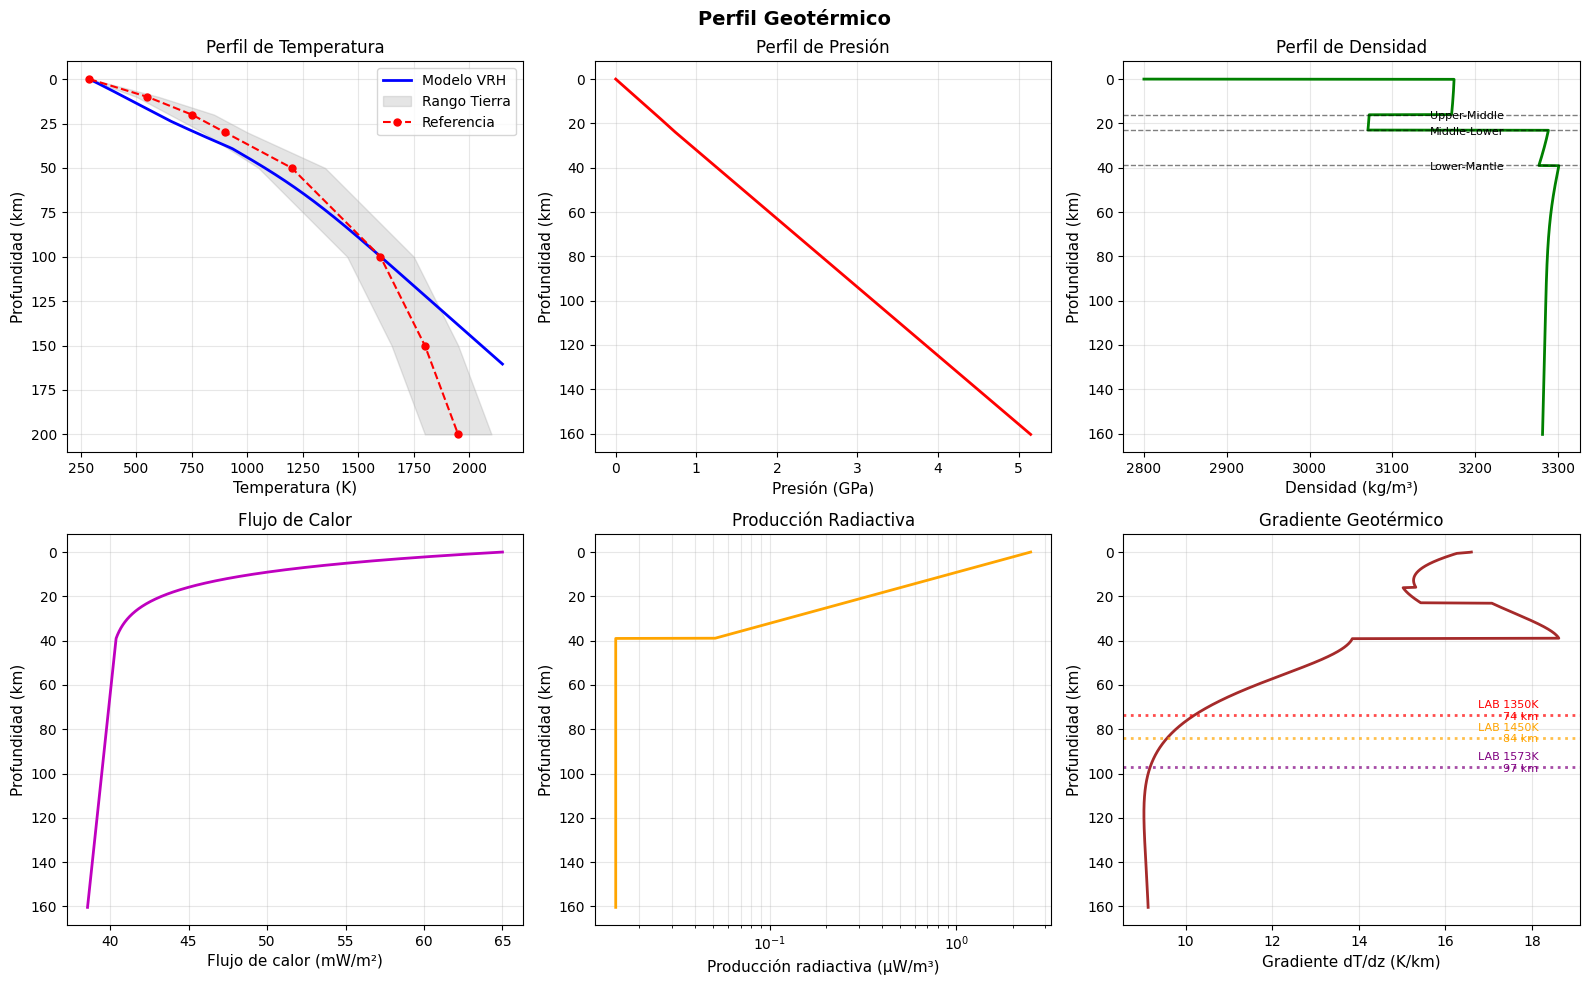

In [11]:
# =============================================================================
# VISUALIZACIÓN: Perfil geotérmico completo
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Perfil Geotérmico', fontsize=14, fontweight='bold')

# 1. Temperatura vs Profundidad
ax1 = axes[0, 0]
ax1.plot(df_geotherm['T_K'], df_geotherm['depth_km'], 'b-', linewidth=2, label='Modelo VRH')
ref_depths = reference_data['depth_km']
ref_T_min = reference_data['T_K_range_min']
ref_T_max = reference_data['T_K_range_max']
ax1.fill_betweenx(ref_depths, ref_T_min, ref_T_max, alpha=0.2, color='gray', label='Rango Tierra')
ax1.plot(reference_data['T_K_continental'], ref_depths, 'ro--', label='Referencia', markersize=5)
ax1.set_xlabel('Temperatura (K)', fontsize=11)
ax1.set_ylabel('Profundidad (km)', fontsize=11)
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_title('Perfil de Temperatura')

# 2. Presión vs Profundidad
ax2 = axes[0, 1]
ax2.plot(df_geotherm['P_Pa'] / 1e9, df_geotherm['depth_km'], 'r-', linewidth=2)
ax2.set_xlabel('Presión (GPa)', fontsize=11)
ax2.set_ylabel('Profundidad (km)', fontsize=11)
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)
ax2.set_title('Perfil de Presión')

# 3. Densidad vs Profundidad
ax3 = axes[0, 2]
ax3.plot(df_geotherm['rho_kg_m3'], df_geotherm['depth_km'], 'g-', linewidth=2)
# Marcar fronteras composicionales
for i, (boundary, label) in enumerate(zip(boundaries, ['Upper-Middle', 'Middle-Lower', 'Lower-Mantle'])):
    ax3.axhline(boundary/1000, color='k', linestyle='--', alpha=0.5, linewidth=1)
    ax3.text(df_geotherm['rho_kg_m3'].max()*0.98, boundary/1000 + 3, label, 
             fontsize=8, ha='right', va='bottom')
ax3.set_xlabel('Densidad (kg/m³)', fontsize=11)
ax3.set_ylabel('Profundidad (km)', fontsize=11)
ax3.invert_yaxis()
ax3.grid(True, alpha=0.3)
ax3.set_title('Perfil de Densidad')

# 4. Flujo de calor vs Profundidad
ax4 = axes[1, 0]
ax4.plot(df_geotherm['q_W_m2'] * 1000, df_geotherm['depth_km'], 'm-', linewidth=2)
ax4.set_xlabel('Flujo de calor (mW/m²)', fontsize=11)
ax4.set_ylabel('Profundidad (km)', fontsize=11)
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3)
ax4.set_title('Flujo de Calor')

# 5. Producción radiactiva vs Profundidad
ax5 = axes[1, 1]
ax5.plot(df_geotherm['A_uW_m3'], df_geotherm['depth_km'], 'orange', linewidth=2)
ax5.set_xlabel('Producción radiactiva (μW/m³)', fontsize=11)
ax5.set_ylabel('Profundidad (km)', fontsize=11)
ax5.invert_yaxis()
ax5.set_xscale('log')
ax5.grid(True, alpha=0.3, which='both')
ax5.set_title('Producción Radiactiva')

# 6. Gradiente geotérmico vs Profundidad
ax6 = axes[1, 2]
dT_dz = np.gradient(df_geotherm['T_K'].values, df_geotherm['depth_km'].values * 1000)
ax6.plot(dT_dz * 1000, df_geotherm['depth_km'], 'brown', linewidth=2)  # K/km
# Marcar LABs
for T_lab, color, label in [(1350, 'red', 'LAB 1350K'), (1450, 'orange', 'LAB 1450K'), (1573, 'purple', 'LAB 1573K')]:
    idx = np.where(df_geotherm['T_K'].values >= T_lab)[0]
    if len(idx) > 0:
        lab_depth = df_geotherm['depth_km'].iloc[idx[0]]
        ax6.axhline(lab_depth, color=color, linestyle=':', alpha=0.7, linewidth=2)
        ax6.text(ax6.get_xlim()[1]*0.95, lab_depth + 3, f'{label}\n{lab_depth:.0f} km', 
                fontsize=8, ha='right', va='bottom', color=color)
ax6.set_xlabel('Gradiente dT/dz (K/km)', fontsize=11)
ax6.set_ylabel('Profundidad (km)', fontsize=11)
ax6.invert_yaxis()
ax6.grid(True, alpha=0.3)
ax6.set_title('Gradiente Geotérmico')

plt.tight_layout()
plt.show()


In [12]:
# =============================================================================
# VALIDACIÓN: Comparar con valores de referencia de la Tierra
# =============================================================================

print("=" * 70)
print("VALIDACIÓN CONTRA VALORES DE REFERENCIA (TIERRA)")
print("=" * 70)

print("\nComparación Temperatura:")
print(f"{'Profundidad':<12} {'Calculado':<12} {'Referencia':<15} {'Rango':<20} {'Status':<10}")
print("-" * 75)

for i, depth in enumerate(reference_data['depth_km']):
    if depth <= df_geotherm['depth_km'].max():
        T_calc = np.interp(depth, df_geotherm['depth_km'], df_geotherm['T_K'])
        T_ref = reference_data['T_K_continental'][i]
        T_min = reference_data['T_K_range_min'][i]
        T_max = reference_data['T_K_range_max'][i]
        
        # Verificar si está en rango
        if T_min <= T_calc <= T_max:
            status = "✓ OK"
        elif abs(T_calc - T_ref) / T_ref < 0.15:  # 15% tolerancia
            status = "~ CERCA"
        else:
            status = "✗ FUERA"
        
        print(f"{depth:<12.0f} {T_calc:<12.1f} {T_ref:<15.1f} [{T_min:.0f}-{T_max:.0f}] {status:<10}")

# Gradiente geotérmico superficial
print("\nGradiente Geotérmico Superficial:")
depths_for_grad = df_geotherm['depth_km'].values[:21]  # Primeros 10 km
temps_for_grad = df_geotherm['T_K'].values[:21]
grad_calc = (temps_for_grad[-1] - temps_for_grad[0]) / (depths_for_grad[-1] - depths_for_grad[0])
print(f"  Calculado (0-10 km): {grad_calc:.1f} K/km")
print(f"  Esperado continental: 25-30 K/km")
print(f"  Esperado oceánico: 40-50 K/km")
if 23 <= grad_calc <= 32:
    print(f"  Status: ✓ Dentro del rango continental")
elif 38 <= grad_calc <= 55:
    print(f"  Status: ✓ Dentro del rango oceánico")
else:
    print(f"  Status: ⚠ Fuera de rangos típicos")

# Flujo de calor superficial
q_surf_calc = df_geotherm['q_W_m2'].iloc[0] * 1000  # mW/m²
print(f"\nFlujo Superficial:")
print(f"  Calculado: {q_surf_calc:.1f} mW/m²")
print(f"  Esperado continental: 40-65 mW/m²")
print(f"  Esperado oceánico: 80-100 mW/m²")
if 38 <= q_surf_calc <= 67:
    print(f"  Status: ✓ Dentro del rango continental")
elif 75 <= q_surf_calc <= 105:
    print(f"  Status: ✓ Dentro del rango oceánico")
else:
    print(f"  Status: ⚠ Fuera de rangos típicos")

print("\n" + "=" * 70)

VALIDACIÓN CONTRA VALORES DE REFERENCIA (TIERRA)

Comparación Temperatura:
Profundidad  Calculado    Referencia      Rango                Status    
---------------------------------------------------------------------------
0            288.0        288.0           [280-295] ✓ OK      
10           445.3        550.0           [500-600] ✗ FUERA   
20           597.4        750.0           [650-850] ✗ FUERA   
30           765.6        900.0           [800-1000] ~ CERCA   
50           1078.9       1200.0          [1050-1350] ✓ OK      
100          1601.2       1600.0          [1450-1750] ✓ OK      
150          2054.7       1800.0          [1650-1950] ~ CERCA   

Gradiente Geotérmico Superficial:
  Calculado (0-10 km): 16.2 K/km
  Esperado continental: 25-30 K/km
  Esperado oceánico: 40-50 K/km
  Status: ⚠ Fuera de rangos típicos

Flujo Superficial:
  Calculado: 65.0 mW/m²
  Esperado continental: 40-65 mW/m²
  Esperado oceánico: 80-100 mW/m²
  Status: ✓ Dentro del rango continental



Ejemplo Usando el grid de Planetas

In [13]:
planetary_grid_path = "PlanetaryGrid"
target_folder = "CMF_0.10-IMF_0.10"
folder_path = os.path.join(planetary_grid_path, target_folder)

df_target = table_model(folder_path)
df_target['P_surf'] = df_target['P_surf'].clip(lower=0.0)
df_target['JQ'] = df_target['JQ'].fillna(65e-3)
df_target.head()

,Mp,Rp,P_surf,rho_surf,T_surf,g_suf,JQ
0,1.0,1.113871,0.0,1000.0,300.0,7.897421,0.031578
1,1.3,1.208395,0.0,1000.0,300.0,8.723296,0.065000
2,1.5,1.250678,0.0,1000.0,300.0,9.396266,0.038573
3,1.7,1.310611,0.0,1000.0,300.0,9.697424,0.040743
4,2.0,1.372360,0.0,1000.0,300.0,10.405165,0.121929


⚠️  T calculada (2150.9 K) excede límite seguro en z = 155.40 km
   Deteniendo cálculo en capa 1554.

📊 Perfil parcial retornado:
   Profundidad calculada: 0 - 155.40 km (de 300.0 km solicitados)
   Temperatura máxima alcanzada: 2150.0 K
   Capas calculadas: 1555 / 3001
   Porcentaje completado: 51.8%



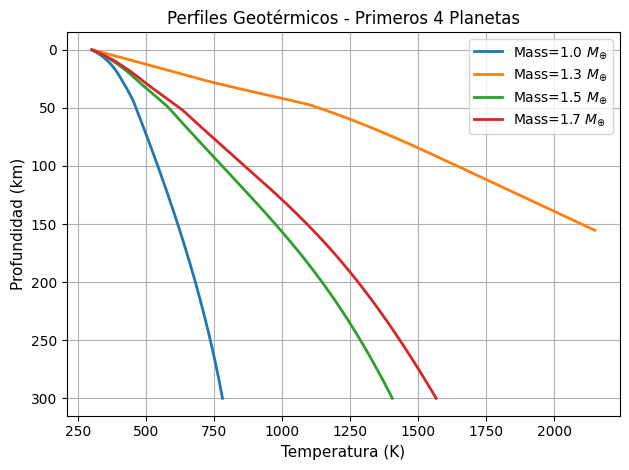

In [14]:
#Para los primeros 5 planetas graficar el perfil geotermico
for index, row in df_target.head(4).iterrows():
    R_planet = row['Rp'] * Re # en metros
    M_total = row['Mp']  * Me # en kg
    P_top = row['P_surf']        # en Pa
    T_top = row['T_surf']        # en K
    rho_top = row['rho_surf']    # en kg/m³
    q_surf = row['JQ']      # en W/m²

    boundaries_scaled = layer_boundaries_scale_radius(
        R_planet,
        ref_boundaries=[16e3, 23e3, 39e3],
        R_ref=Re,
        max_fraction_of_radius=0.5
    )

    df_planet = Data_perfiles(
        rocks=rocks,
        q_s=q_surf,           # 65 mW/m²
        z_max=300e3,         # 300 km
        dz=100.0,            # 100 m
        R_planet=R_planet,
        M_total=M_total,
        composition=composition,
        boundaries=boundaries_scaled,
        T_top=T_top,
        P_top=P_top,
        rho_top=rho_top,
        # Modelo exponencial por defecto:
        A_surface=2.5e-6,    # 2.5 μW/m³
        h_r=10e3,            # 10 km
        A_mantle=0.015e-6    # 0.015 μW/m³
    )

    plt.plot(df_planet['T_K'], df_planet['depth_km'], label=f'Mass={row["Mp"]:.1f} $M_⊕$', linewidth=2)

plt.xlabel('Temperatura (K)', fontsize=11)
plt.ylabel('Profundidad (km)', fontsize=11)
plt.title('Perfiles Geotérmicos - Primeros 4 Planetas')
plt.legend()
plt.grid()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Gradiente vs Tiempo (Tierra)

Queremos ver como varia el gradiente geotermico a lo largo de la vida de un planeta para eso debemos de ver como varia el flujo de calor superficial q_s a lo largo de la vida del planeta

In [15]:
# =============================================================================
# MODELO DE EVOLUCIÓN TEMPORAL DEL GRADIENTE GEOTÉRMICO
# Modelo 1: Turcotte & Schubert (2014)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. MODELO DE FLUJO DE CALOR TEMPORAL (Turcotte)
# -----------------------------------------------------------------------------

def q_s_Turcotte(t_Ga, q0=65e-3, tau=2.0):
    """
    Modelo de Turcotte & Schubert (2014): Decaimiento exponencial simple.
    
    Parameters
    ----------
    t_Ga : float or array
        Tiempo antes del presente [Ga] (positivo hacia el pasado)
    q0 : float
        Flujo de calor superficial actual [W/m²]
        Default: 65e-3 W/m² (65 mW/m²)
    tau : float
        Escala de tiempo característica [Ga]
        Default: 2.0 Ga (tiempo de decaimiento efectivo de elementos radiactivos)
    
    Returns
    -------
    float or array
        Flujo de calor superficial [W/m²]
    
    Notes
    -----
    - Simple y robusto
    - Basado en decaimiento radiactivo promedio
    - t = 0: presente (q_s = 65 mW/m²)
    - t = 4.5 Ga: formación de la Tierra (q_s ~ 778 mW/m²)
    
    Ejemplos:
    - t = 0 Ga (presente): q_s = 65 mW/m²
    - t = 1.0 Ga: q_s ≈ 107 mW/m²
    - t = 2.5 Ga: q_s ≈ 225 mW/m²
    - t = 4.5 Ga (formación): q_s ≈ 778 mW/m²
    
    Reference
    ---------
    Turcotte & Schubert (2014), Geodynamics, 3rd edition
    """
    return q0 * np.exp(t_Ga / tau)


# -----------------------------------------------------------------------------
# 2. PRODUCCIÓN RADIACTIVA TEMPORAL
# -----------------------------------------------------------------------------

def A_surface_temporal(t_Ga, A0=2.5e-6, tau=2.0):
    """
    Producción radiactiva superficial en función del tiempo.
    
    Parameters
    ----------
    t_Ga : float or array
        Tiempo antes del presente [Ga]
    A0 : float
        Producción radiactiva actual [W/m³]
        Default: 2.5e-6 W/m³ (2.5 μW/m³)
    tau : float
        Escala de tiempo del decaimiento [Ga]
        Default: 2.0 Ga
    
    Returns
    -------
    float or array
        Producción radiactiva superficial [W/m³]
    
    Notes
    -----
    - Sigue el mismo decaimiento exponencial que el flujo de calor
    - En el pasado había más elementos radiactivos
    - Contribuye al perfil geotérmico: A(z,t) = A_surface(t) * exp(-z/h_r)
    """
    return A0 * np.exp(t_Ga / tau)


# -----------------------------------------------------------------------------
# 3. CÁLCULO DE EVOLUCIÓN TEMPORAL
# -----------------------------------------------------------------------------

def calculate_geotherm_evolution(
    rocks,
    composition,
    R_planet=6.371e6,
    M_total=5.972e24,
    z_max=100e3, 
    dz=100.0,
    boundaries=[16e3, 23e3, 39e3],
    T_top=288.0,
    h_r=10e3,
    q0=65e-3,
    tau=2.0,
    t_Ga=np.linspace(0, 2., 5)
):
    """
    Calcula la evolución temporal del gradiente geotérmico usando el modelo de Turcotte.
    
    Parameters
    ----------
    rocks : dict
        Diccionario de composites minerales por capa (upper, middle, lower, mantle)
    composition : dict
        Diccionario de composiciones modales por capa
    R_planet : float
        Radio del planeta [m]
        Default: 6.371e6 m (Radio de la Tierra)
    M_total : float
        Masa del planeta [kg]
        Default: 5.972e24 kg (Masa de la Tierra)
    z_max : float
        Profundidad máxima [m]
    dz : float
        Paso de profundidad [m]
    boundaries : list
        Fronteras de capas [d1, d2, d3] [m]
    T_top : float
        Temperatura superficial [K]
    h_r : float
        Profundidad característica de producción radiactiva [m]
    q0 : float
        Flujo de calor superficial actual [W/m²]
        Default: 65e-3 W/m² (65 mW/m²)
    tau : float
        Escala de tiempo del decaimiento [Ga]
        Default: 2.0 Ga
    t_Ga : array
        Tiempos a calcular [Ga]
        Default: np.linspace(0, 2., 5)
    
    Returns
    -------
    dict
        Diccionario con resultados:
        - 't_Ga': array de tiempos [Ga]
        - 'q_s': array de flujos de calor superficiales [W/m²]
        - 'profiles': lista de DataFrames con perfiles geotérmicos
        - 'gradients': array de gradientes superficiales [K/km]
    
    Notes
    -----
    - Usa modelo de Turcotte & Schubert (2014): q_s(t) = q0 * exp(t/tau)
    - Calcula perfiles T(z) para múltiples tiempos
    - Usa Data_perfiles() para cada tiempo
    - Extrae gradiente superficial de cada perfil (primeros 1 km)
    - ADVERTENCIA: Para tiempos muy antiguos (>2 Ga), el flujo de calor puede ser
      demasiado alto y causar fallos en BurnMan por temperaturas excesivas
    
    Ejemplo
    -------
    >>> # Recomendado: limitar a 0-2 Ga para evitar problemas con altas T
    >>> t_custom = np.linspace(0, 2.0, 10)  # 0 a 2 Ga
    >>> results = calculate_geotherm_evolution(
    ...     rocks=rocks, 
    ...     composition=composition,
    ...     n_times=10
    ... )
    >>> plot_gradient_evolution(results)
    """
    
    # Calcular flujos de calor con modelo de Turcotte
    q_s = q_s_Turcotte(t_Ga, q0=q0, tau=tau)
    
    # Calcular perfiles geotérmicos para cada tiempo
    profiles = []
    gradients = []
    
    print("=" * 80)
    print(f"CALCULANDO EVOLUCIÓN TEMPORAL DEL GRADIENTE GEOTÉRMICO")
    print(f"Modelo: Turcotte & Schubert (2014)")
    print(f"Número de tiempos: {len(t_Ga)}")
    print(f"R_planet = {R_planet/1e6:.3f} x 10^6 m")
    print(f"M_total = {M_total/1e24:.3f} x 10^24 kg")
    print("=" * 80)
    
    for i, (t, q) in enumerate(zip(t_Ga, q_s)):
        # Producción radiactiva para este tiempo
        A_surf = A_surface_temporal(t)
        
        # Calcular perfil geotérmico
        df = Data_perfiles(
            rocks=rocks,
            q_s=q,
            z_max=z_max,
            dz=dz,
            R_planet=R_planet,
            M_total=M_total,
            composition=composition,
            boundaries=boundaries,
            T_top=T_top,
            A_surface=A_surf,
            h_r=h_r
        )
        
        profiles.append(df)
        
        # Calcular gradiente superficial (primeros 1 km)
        idx_1km = np.argmin(np.abs(df['depth_km'] - 1.0))
        dT = df['T_K'].iloc[idx_1km] - df['T_K'].iloc[0]
        dz_km = df['depth_km'].iloc[idx_1km]
        gradient = dT / dz_km  # [K/km]
        gradients.append(gradient)
        
        print(f"  t = {t:6.3f} Ga | q_s = {q*1000:6.1f} mW/m² | dT/dz = {gradient:5.1f} K/km")
    
    print("=" * 80)
    
    return {
        't_Ga': t_Ga,
        'q_s': q_s,
        'profiles': profiles,
        'gradients': np.array(gradients)
    }


# -----------------------------------------------------------------------------
# 4. VISUALIZACIÓN
# -----------------------------------------------------------------------------

def plot_gradient_evolution(results, save_path=None):
    """
    Grafica la evolución temporal del gradiente geotérmico.
    
    Parameters
    ----------
    results : dict
        Diccionario retornado por calculate_geotherm_evolution()
    save_path : str, optional
        Ruta para guardar la figura
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    t_Ga = results['t_Ga']
    q_s = results['q_s']
    gradients = results['gradients']
    profiles = results['profiles']
    
    # Panel 1: Flujo de calor vs tiempo
    ax1 = axes[0, 0]
    ax1.plot(t_Ga, q_s * 1000, 'ro-', linewidth=2, markersize=6)
    ax1.set_xlabel('Tiempo antes del presente (Ga)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Flujo de calor superficial (mW/m²)', fontsize=12, fontweight='bold')
    ax1.set_title('Evolución del Flujo de Calor Superficial', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.invert_xaxis()  # Tiempo hacia atrás (presente a la derecha)
    
    # Panel 2: Gradiente vs tiempo
    ax2 = axes[0, 1]
    ax2.plot(t_Ga, gradients, 'bo-', linewidth=2, markersize=6)
    ax2.set_xlabel('Tiempo antes del presente (Ga)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Gradiente geotérmico (K/km)', fontsize=12, fontweight='bold')
    ax2.set_title('Evolución del Gradiente Geotérmico Superficial', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.invert_xaxis()
    
    # Panel 3: Perfiles T(z) para diferentes tiempos
    ax3 = axes[1, 0]
    cmap = plt.cm.plasma
    colors = [cmap(i / len(profiles)) for i in range(len(profiles))]
    
    for i, (t, df) in enumerate(zip(t_Ga, profiles)):
        ax3.plot(df['T_K'], df['depth_km'], color=colors[i], linewidth=2,
                label=f'{t:.2f} Ga')
    
    ax3.set_xlabel('Temperatura (K)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Profundidad (km)', fontsize=12, fontweight='bold')
    ax3.set_title('Perfiles Geotérmicos a Diferentes Tiempos', fontsize=13, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=8, ncol=2)
    ax3.set_xlim(200, 2000)
    ax3.set_ylim(100, 0)
    
    # Panel 4: Gradiente vs q_s (relación directa)
    ax4 = axes[1, 1]
    ax4.scatter(q_s * 1000, gradients, c=t_Ga, cmap='viridis', s=100, edgecolors='black')
    cbar = plt.colorbar(ax4.collections[0], ax=ax4, label='Tiempo (Ga)')
    ax4.set_xlabel('Flujo de calor superficial (mW/m²)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Gradiente geotérmico (K/km)', fontsize=12, fontweight='bold')
    ax4.set_title('Gradiente vs Flujo de Calor (color = tiempo)', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Ajuste lineal
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(q_s * 1000, gradients)
    x_fit = np.linspace(q_s.min() * 1000, q_s.max() * 1000, 100)
    y_fit = slope * x_fit + intercept
    ax4.plot(x_fit, y_fit, 'r--', linewidth=2, 
            label=f'Ajuste: dT/dz = {slope:.2f}·q_s + {intercept:.1f}\nR² = {r_value**2:.3f}')
    ax4.legend(fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig, axes




## Ejemplo de Uso: Evolución Temporal del Gradiente Geotérmico

Ahora vamos a calcular cómo varía el gradiente geotérmico a lo largo del tiempo geológico usando el **modelo de Turcotte & Schubert (2014)**.

In [16]:
# =============================================================================
# EJEMPLO: EVOLUCIÓN DEL GRADIENTE GEOTÉRMICO (0-2 Ga)
# =============================================================================


t_geological = np.array([
    0.0,    # Presente (Holoceno)
    0.066,  # Inicio del Cenozoico (extinción de dinosaurios)
    0.252,  # Pérmico-Triásico (Gran extinción)
    0.419,  # Inicio del Devónico (era de los peces)
    0.541,  # Inicio del Fanerozoico (Explosión Cámbrica)
    1, 
    1.5,
    2.0
])

q_times = q_s_Turcotte(t_geological) * 1000  # Convertir a mW/m²
q_times



array([ 65.        ,  67.18078505,  73.72834094,  80.14898938,
        85.19027379, 107.1668826 , 137.60500108, 176.68831885])

In [17]:
# Calcular evolución temporal
results_Turcotte = calculate_geotherm_evolution(
    rocks=rocks,
    composition=composition,
    R_planet=Re,
    M_total=Me,
    z_max=100e3,  # 100 km de profundidad
    dz=100.0,     # 100 m de resolución
    boundaries=boundaries,
    T_top=Tsurface,
    h_r=10e3,
    q0=65e-3,     # 65 mW/m² actual
    tau=2.0,      # Escala de tiempo 2 Ga
    t_Ga=t_geological
)

CALCULANDO EVOLUCIÓN TEMPORAL DEL GRADIENTE GEOTÉRMICO
Modelo: Turcotte & Schubert (2014)
Número de tiempos: 8
R_planet = 6.378 x 10^6 m
M_total = 5.972 x 10^24 kg
  t =  0.000 Ga | q_s =   65.0 mW/m² | dT/dz =  16.6 K/km
  t =  0.000 Ga | q_s =   65.0 mW/m² | dT/dz =  16.6 K/km
  t =  0.066 Ga | q_s =   67.2 mW/m² | dT/dz =  17.2 K/km
  t =  0.066 Ga | q_s =   67.2 mW/m² | dT/dz =  17.2 K/km
  t =  0.252 Ga | q_s =   73.7 mW/m² | dT/dz =  18.9 K/km
  t =  0.252 Ga | q_s =   73.7 mW/m² | dT/dz =  18.9 K/km
  t =  0.419 Ga | q_s =   80.1 mW/m² | dT/dz =  20.6 K/km
  t =  0.419 Ga | q_s =   80.1 mW/m² | dT/dz =  20.6 K/km
  t =  0.541 Ga | q_s =   85.2 mW/m² | dT/dz =  21.9 K/km
  t =  0.541 Ga | q_s =   85.2 mW/m² | dT/dz =  21.9 K/km
⚠️  T calculada (2151.5 K) excede límite seguro en z = 83.10 km
   Deteniendo cálculo en capa 831.

📊 Perfil parcial retornado:
   Profundidad calculada: 0 - 83.10 km (de 100.0 km solicitados)
   Temperatura máxima alcanzada: 2149.9 K
   Capas calculadas: 

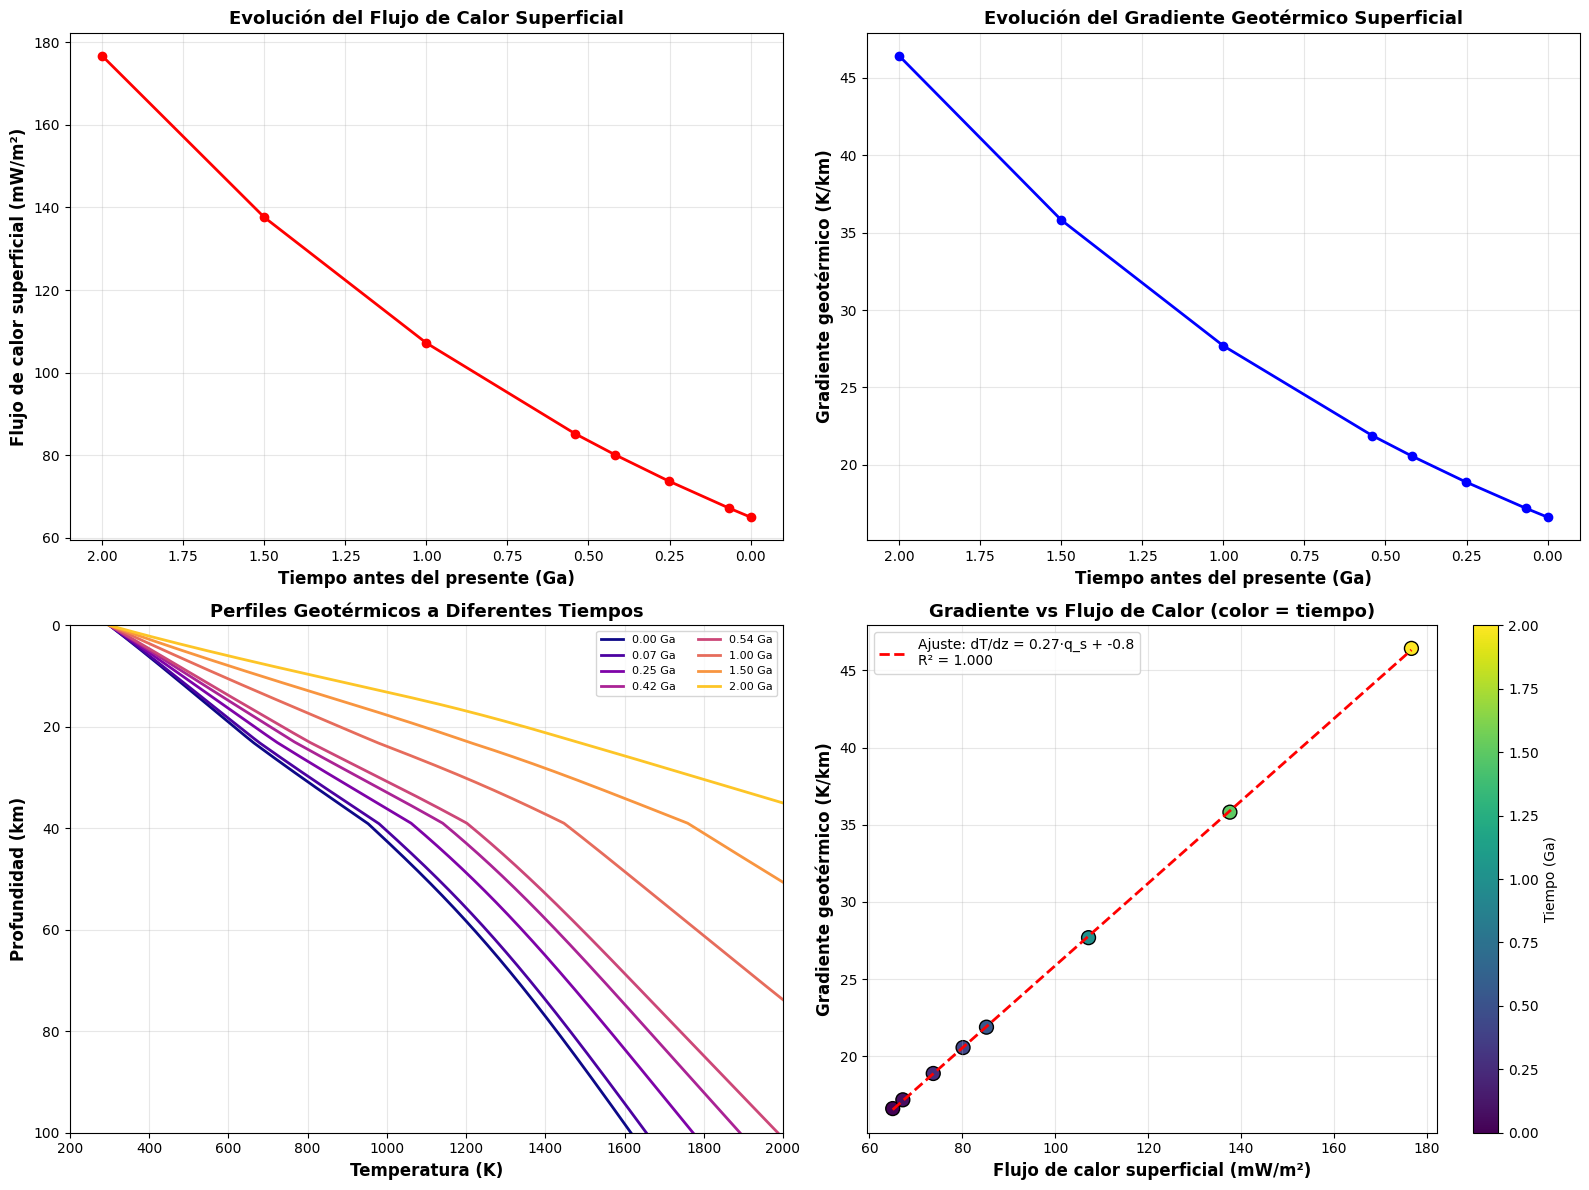

(<Figure size 1600x1200 with 5 Axes>,
 array([[<Axes: title={'center': 'Evolución del Flujo de Calor Superficial'}, xlabel='Tiempo antes del presente (Ga)', ylabel='Flujo de calor superficial (mW/m²)'>,
         <Axes: title={'center': 'Evolución del Gradiente Geotérmico Superficial'}, xlabel='Tiempo antes del presente (Ga)', ylabel='Gradiente geotérmico (K/km)'>],
        [<Axes: title={'center': 'Perfiles Geotérmicos a Diferentes Tiempos'}, xlabel='Temperatura (K)', ylabel='Profundidad (km)'>,
         <Axes: title={'center': 'Gradiente vs Flujo de Calor (color = tiempo)'}, xlabel='Flujo de calor superficial (mW/m²)', ylabel='Gradiente geotérmico (K/km)'>]],
       dtype=object))

In [18]:
# Visualizar resultados
plot_gradient_evolution(results_Turcotte)

CALCULANDO EVOLUCIÓN TEMPORAL DEL GRADIENTE GEOTÉRMICO
Modelo: Turcotte & Schubert (2014)
Número de tiempos: 8
R_planet = 6.378 x 10^6 m
M_total = 5.972 x 10^24 kg
  t =  0.000 Ga | q_s =   65.0 mW/m² | dT/dz =  16.6 K/km
  t =  0.000 Ga | q_s =   65.0 mW/m² | dT/dz =  16.6 K/km
  t =  0.066 Ga | q_s =   67.2 mW/m² | dT/dz =  17.2 K/km
  t =  0.066 Ga | q_s =   67.2 mW/m² | dT/dz =  17.2 K/km
  t =  0.252 Ga | q_s =   73.7 mW/m² | dT/dz =  18.9 K/km
  t =  0.252 Ga | q_s =   73.7 mW/m² | dT/dz =  18.9 K/km
  t =  0.419 Ga | q_s =   80.1 mW/m² | dT/dz =  20.6 K/km
  t =  0.419 Ga | q_s =   80.1 mW/m² | dT/dz =  20.6 K/km
  t =  0.541 Ga | q_s =   85.2 mW/m² | dT/dz =  21.9 K/km
  t =  0.541 Ga | q_s =   85.2 mW/m² | dT/dz =  21.9 K/km
⚠️  T calculada (2151.5 K) excede límite seguro en z = 83.10 km
   Deteniendo cálculo en capa 831.

📊 Perfil parcial retornado:
   Profundidad calculada: 0 - 83.10 km (de 100.0 km solicitados)
   Temperatura máxima alcanzada: 2149.9 K
   Capas calculadas: 

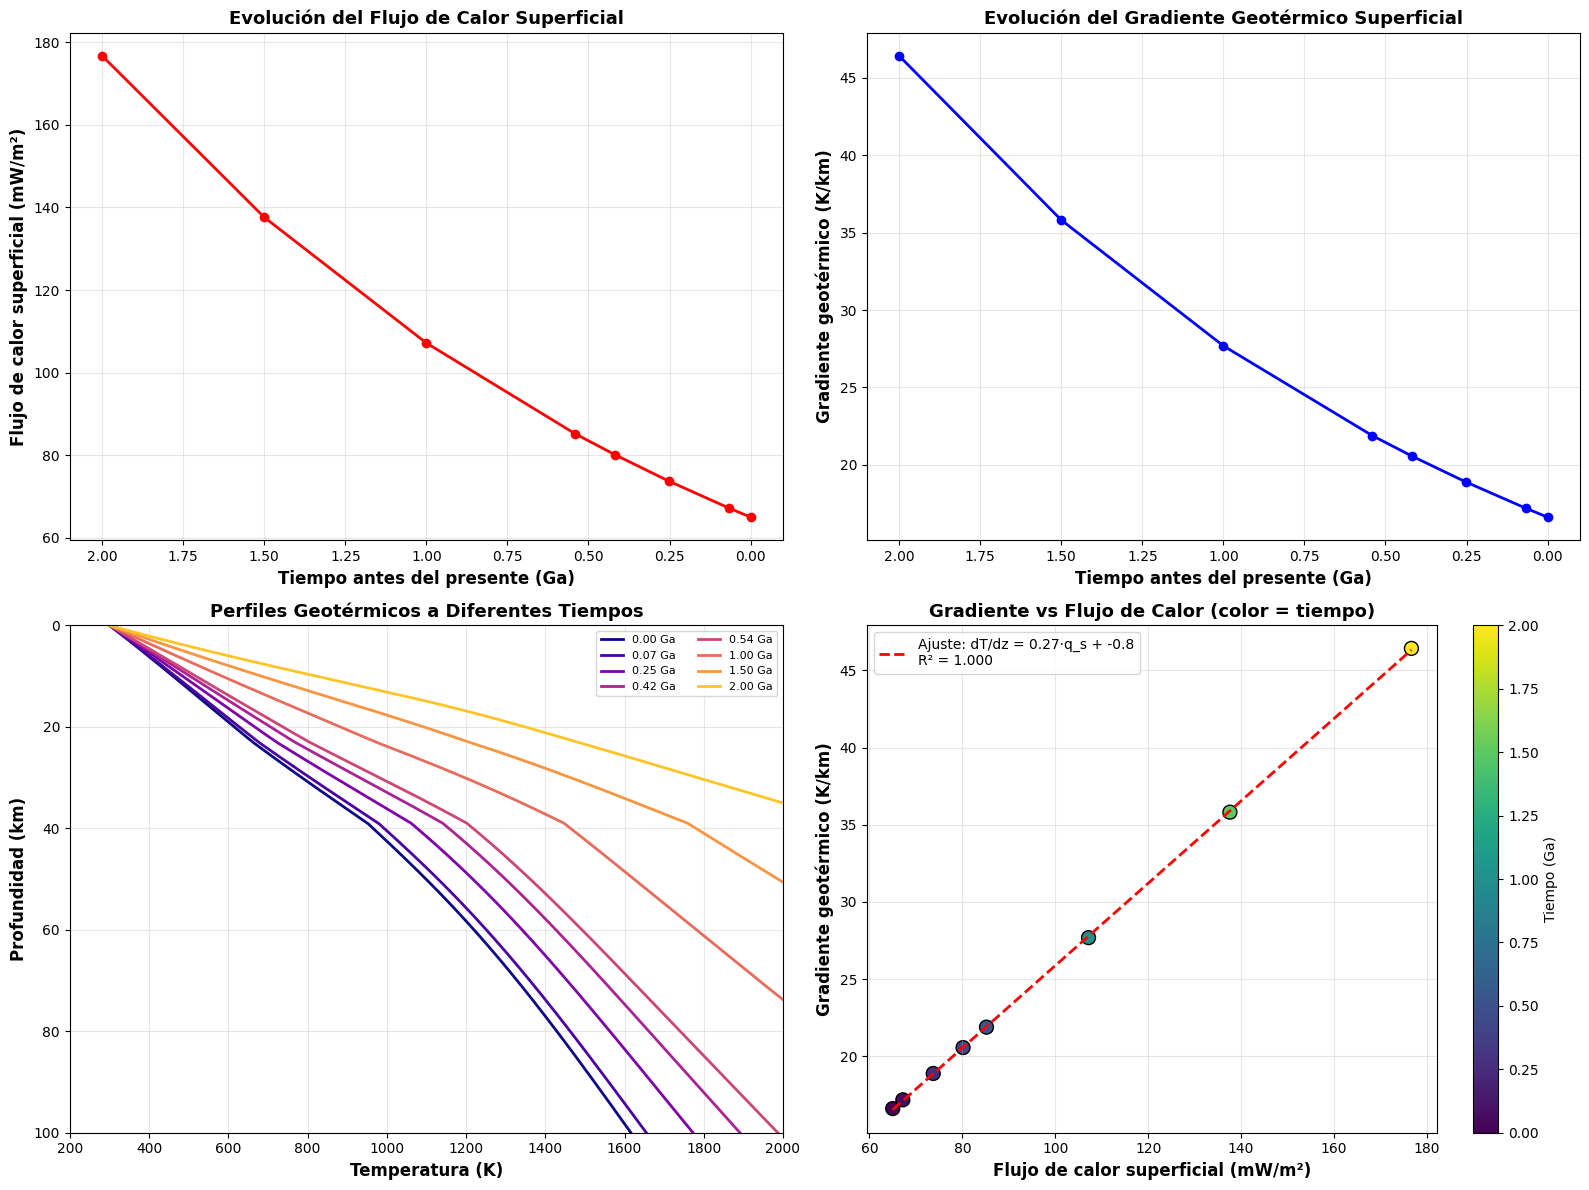

(<Figure size 1600x1200 with 5 Axes>,
 array([[<Axes: title={'center': 'Evolución del Flujo de Calor Superficial'}, xlabel='Tiempo antes del presente (Ga)', ylabel='Flujo de calor superficial (mW/m²)'>,
         <Axes: title={'center': 'Evolución del Gradiente Geotérmico Superficial'}, xlabel='Tiempo antes del presente (Ga)', ylabel='Gradiente geotérmico (K/km)'>],
        [<Axes: title={'center': 'Perfiles Geotérmicos a Diferentes Tiempos'}, xlabel='Temperatura (K)', ylabel='Profundidad (km)'>,
         <Axes: title={'center': 'Gradiente vs Flujo de Calor (color = tiempo)'}, xlabel='Flujo de calor superficial (mW/m²)', ylabel='Gradiente geotérmico (K/km)'>]],
       dtype=object))

In [19]:
import geotherm_calculator as gc


result = gc.calculate_geotherm_evolution(
    rocks=rocks,
    composition=composition,
    R_planet=Re,
    M_total=Me,
    z_max=100e3,  # 100 km de profundidad
    dz=100.0,     # 100 m de resolución
    boundaries=boundaries,
    T_top=Tsurface,
    h_r=10e3,
    q0=65e-3,     # 65 mW/m² actual
    tau=2.0,      # Escala de tiempo 2 Ga
    t_Ga=t_geological)

plot_gradient_evolution(result)
